# Mixed Momentum Strategy

Author: Nicolas Harvie 

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from warnings import filterwarnings
filterwarnings('ignore')

path_intermediate = '../yilin_material/'

In [47]:
signals_master = pd.read_csv(path_intermediate + 'SignalMasterTable.csv', index_col=['Unnamed: 0'], parse_dates=['time_avail_m'])
signals_master

,permno,ret,prc,shrcd,exchcd,sicCRSP,ticker,time_avail_m,mve_c,gvkey,sicCS,tickerIBES,NYSE,bh1m
0,10000.0,NaN,-4.375000,10.0,3.0,3990.0,OMFGA,1986-01-01,1.610000e+01,NaN,NaN,NaN,0.0,-0.257143
1,10000.0,-0.257143,-3.250000,10.0,3.0,3990.0,OMFGA,1986-02-01,1.196000e+01,NaN,NaN,NaN,0.0,0.365385
2,10000.0,0.365385,-4.437500,10.0,3.0,3990.0,OMFGA,1986-03-01,1.633000e+01,NaN,NaN,NaN,0.0,-0.098592
3,10000.0,-0.098592,-4.000000,10.0,3.0,3990.0,OMFGA,1986-04-01,1.517200e+01,NaN,NaN,NaN,0.0,-0.222656
4,10000.0,-0.222656,-3.109375,10.0,3.0,3990.0,OMFGA,1986-05-01,1.179386e+01,NaN,NaN,NaN,0.0,-0.005025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3879455,93436.0,0.027612,1144.760010,11.0,3.0,9999.0,TSLA,2021-11-01,1.149642e+06,184996.0,3711.0,TSLA,0.0,-0.076855
3879456,93436.0,-0.076855,1056.780029,11.0,3.0,9999.0,TSLA,2021-12-01,1.092218e+06,184996.0,3711.0,TSLA,0.0,-0.113609
3879457,93436.0,-0.113609,936.719971,11.0,3.0,9999.0,TSLA,2022-01-01,9.681319e+05,184996.0,3711.0,TSLA,0.0,-0.070768
3879458,93436.0,-0.070768,870.429993,11.0,3.0,9999.0,TSLA,2022-02-01,8.996190e+05,184996.0,3711.0,TSLA,0.0,0.238009


In [87]:
daily_crsp = pd.read_csv(path_intermediate + 'dailyCRSP.csv')
daily_crsp


,Unnamed: 0,permno,date,ret,vol,shrout,prc,cfacpr
0,0,10006.0,1926-01-02,0.001147,700.0,600.0,109.125000,7.412625
1,1,10022.0,1926-01-02,0.004464,100.0,200.0,56.250000,9.365437
2,2,10030.0,1926-01-02,NaN,NaN,156.0,NaN,9.969793
3,3,10049.0,1926-01-02,-0.010135,0.0,250.0,-73.250000,2.000000
4,4,10057.0,1926-01-02,0.010204,900.0,500.0,12.375000,4.000000
...,...,...,...,...,...,...,...,...
101069890,583361,93426.0,2022-03-31,-0.018920,52630.0,12612.0,32.150002,1.000000
101069891,583362,93427.0,2022-03-31,-0.001614,166895.0,36995.0,105.129997,1.000000
101069892,583363,93429.0,2022-03-31,-0.002354,1001261.0,106602.0,114.419998,1.000000
101069893,583364,93434.0,2022-03-31,-0.036199,107568.0,38908.0,2.130000,1.000000


In [97]:
daily_crsp['date'] = pd.to_datetime(daily_crsp['date'])

***
## Firm-Age Momentum Signal

In [48]:
# New signal master to create the strategy dataframe 
strat_df = signals_master.copy()

# Counting firm age by cumulative count of PERMNOs
strat_df.sort_values(['permno','time_avail_m'], inplace=True)
strat_df['tempage'] = strat_df.groupby(['permno']).cumcount()+1

In [49]:
# Getting logarithmic returns for summability
strat_df['ret'] = np.log(1 + strat_df['ret'])

# Computing Cumulative Returns over past period for Momentum 
# Window is flexible, we use 12 months as per the literature
strat_df['firm_age_mom'] = strat_df.groupby('permno')['ret'].shift(1).rolling(window=12).sum().reset_index(level=0, drop=True)

In [50]:
# Quantile Transform for momentum 
# Add an indicator variable which returns 1 if condition is met or zero otherwise 
# Will be helpful when we do the interaction of various conditions for the LS portfolio creation 
strat_df['mom_high'] = strat_df['ret'] > strat_df.groupby('time_avail_m')['ret'].transform('quantile', 0.8)
strat_df['mom_low'] = strat_df['ret'] < strat_df.groupby('time_avail_m')['ret'].transform('quantile', 0.2)

In [51]:
# Quantile Transform for age 
strat_df['age_low'] = strat_df['tempage'] < strat_df.groupby('time_avail_m')['tempage'].transform('quantile', 0.2)
strat_df['age_high'] = strat_df['tempage'] > strat_df.groupby('time_avail_m')['tempage'].transform('quantile', 0.8)

In [52]:
# Some basic Filtering 
# Will eventually remove the values associated to those conditons
strat_df['firm_age_mom'].loc[(np.abs(strat_df['prc'])<5) | (strat_df['tempage']<12)] = np.nan

In [53]:
# Note the conditions at the last columns
strat_df

,permno,ret,prc,shrcd,exchcd,sicCRSP,ticker,time_avail_m,mve_c,gvkey,sicCS,tickerIBES,NYSE,bh1m,tempage,firm_age_mom,mom_high,mom_low,age_low,age_high
0,10000.0,NaN,-4.375000,10.0,3.0,3990.0,OMFGA,1986-01-01,1.610000e+01,NaN,NaN,NaN,0.0,-0.257143,1,NaN,False,False,True,False
1,10000.0,-0.297252,-3.250000,10.0,3.0,3990.0,OMFGA,1986-02-01,1.196000e+01,NaN,NaN,NaN,0.0,0.365385,2,NaN,False,True,True,False
2,10000.0,0.311436,-4.437500,10.0,3.0,3990.0,OMFGA,1986-03-01,1.633000e+01,NaN,NaN,NaN,0.0,-0.098592,3,NaN,True,False,True,False
3,10000.0,-0.103797,-4.000000,10.0,3.0,3990.0,OMFGA,1986-04-01,1.517200e+01,NaN,NaN,NaN,0.0,-0.222656,4,NaN,False,True,True,False
4,10000.0,-0.251873,-3.109375,10.0,3.0,3990.0,OMFGA,1986-05-01,1.179386e+01,NaN,NaN,NaN,0.0,-0.005025,5,NaN,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3879455,93436.0,0.027238,1144.760010,11.0,3.0,9999.0,TSLA,2021-11-01,1.149642e+06,184996.0,3711.0,TSLA,0.0,-0.076855,138,1.054604,True,False,False,False
3879456,93436.0,-0.079968,1056.780029,11.0,3.0,9999.0,TSLA,2021-12-01,1.092218e+06,184996.0,3711.0,TSLA,0.0,-0.113609,139,0.701533,False,False,False,False
3879457,93436.0,-0.120597,936.719971,11.0,3.0,9999.0,TSLA,2022-01-01,9.681319e+05,184996.0,3711.0,TSLA,0.0,-0.070768,140,0.403834,False,False,False,False
3879458,93436.0,-0.073397,870.429993,11.0,3.0,9999.0,TSLA,2022-02-01,8.996190e+05,184996.0,3711.0,TSLA,0.0,0.238009,141,0.165893,False,False,False,False


***
## Announcement Returns

In [54]:
# Homemade CSV containing earnings data for all equities in a given timeperiod
earnings = pd.read_csv('./earnings.csv')
earnings = earnings.dropna(subset=['rdq', 'epsfxq'])

In [55]:
earnings

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,datacqtr,datafqtr,rdq,epsfxq,costat
24,1000,1972-03-31,1972,1.0,INDL,C,D,STD,USD,1972Q1,1972Q1,1972-04-20,0.10,I
25,1000,1972-06-30,1972,2.0,INDL,C,D,STD,USD,1972Q2,1972Q2,1972-07-24,0.17,I
26,1000,1972-09-30,1972,3.0,INDL,C,D,STD,USD,1972Q3,1972Q3,1972-10-17,0.13,I
27,1000,1972-12-31,1972,4.0,INDL,C,D,STD,USD,1972Q4,1972Q4,1973-02-15,0.12,I
28,1000,1973-03-31,1973,1.0,INDL,C,D,STD,USD,1973Q1,1973Q1,1973-04-23,0.13,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965088,353444,2022-06-30,2022,2.0,INDL,C,D,STD,USD,2022Q2,2022Q2,2022-09-20,0.04,A
1965089,353444,2022-09-30,2022,3.0,INDL,C,D,STD,USD,2022Q3,2022Q3,2022-11-10,0.07,A
1965090,353444,2022-12-31,2022,4.0,INDL,C,D,STD,USD,2022Q4,2022Q4,2023-03-02,0.07,A
1965091,353444,2023-03-31,2023,1.0,INDL,C,D,STD,USD,2023Q1,2023Q1,2023-05-03,0.10,A


In [56]:
### EARNINGS RATIO CALCULATION ###

# Taking the difference over the EPS for each asset 
earnings['diff_eps'] = earnings.groupby('gvkey')['epsfxq'].diff(3)
earnings = earnings.dropna(subset='diff_eps')

# Rolling standard deviation over the past differences 
earnings['std_diff_eps'] = earnings['diff_eps'].rolling(3).std()

# SUE 
earnings['sue'] = earnings['diff_eps'] / earnings['std_diff_eps']
earnings = earnings.dropna(subset='sue')

In [57]:
earnings

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,datacqtr,datafqtr,rdq,epsfxq,costat,diff_eps,std_diff_eps,sue
29,1000,1973-06-30,1973,2.0,INDL,C,D,STD,USD,1973Q2,1973Q2,1973-07-31,0.18,I,0.05,0.045826,1.091089
30,1000,1973-09-30,1973,3.0,INDL,C,D,STD,USD,1973Q3,1973Q3,1973-10-24,0.06,I,-0.06,0.058595,-1.023984
31,1000,1973-12-31,1973,4.0,INDL,C,D,STD,USD,1973Q4,1973Q4,1974-02-27,0.25,I,0.12,0.090738,1.322493
32,1000,1974-03-31,1974,1.0,INDL,C,D,STD,USD,1974Q1,1974Q1,1974-04-17,0.13,I,-0.05,0.101160,-0.494267
33,1000,1974-06-30,1974,2.0,INDL,C,D,STD,USD,1974Q2,1974Q2,1974-07-25,0.23,I,0.17,0.115326,1.474087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965081,351590,2022-09-30,2022,3.0,INDL,C,D,STD,USD,2022Q3,2022Q3,2022-11-11,0.52,A,0.63,0.076775,8.205839
1965082,351590,2022-12-31,2022,4.0,INDL,C,D,STD,USD,2022Q4,2022Q4,2023-03-10,0.46,A,0.36,0.126073,2.855494
1965089,353444,2022-09-30,2022,3.0,INDL,C,D,STD,USD,2022Q3,2022Q3,2022-11-10,0.07,A,-0.09,0.359111,-0.250619
1965090,353444,2022-12-31,2022,4.0,INDL,C,D,STD,USD,2022Q4,2022Q4,2023-03-02,0.07,A,-0.03,0.237405,-0.126366


In [58]:
# Dates to merge
earnings['datadate'] = pd.to_datetime(earnings['datadate']) + pd.DateOffset(days=1)
earnings = earnings.rename(columns ={'datadate': 'time_avail_m'})
earnings.index = earnings['time_avail_m']

# Resample to forward fill the measures
sue_df = earnings.groupby('gvkey')['sue'].resample('MS').first().ffill().reset_index()
full_df = pd.merge(strat_df, sue_df, on=['gvkey', 'time_avail_m'])

In [59]:
# Quantile Transform for age 
full_df['sue_low'] = full_df['sue'] < full_df.groupby('time_avail_m')['sue'].transform('quantile', 0.2)
full_df['sue_high'] = full_df['sue'] > full_df.groupby('time_avail_m')['sue'].transform('quantile', 0.8)

In [60]:
# This should be sufficient to create long short portfolio 
full_df

,permno,ret,prc,shrcd,exchcd,sicCRSP,ticker,time_avail_m,mve_c,gvkey,...,bh1m,tempage,firm_age_mom,mom_high,mom_low,age_low,age_high,sue,sue_low,sue_high
0,10001.0,0.021053,6.000000,11.0,3.0,4920.0,GFGC,1987-07-01,5.946000e+00,12994.0,...,0.083333,19,0.023603,False,False,False,False,0.693870,False,False
1,10001.0,0.080043,6.500000,11.0,3.0,4920.0,GFGC,1987-08-01,6.441500e+00,12994.0,...,-0.022308,20,0.054913,False,False,False,False,0.693870,False,False
2,10001.0,-0.022560,6.250000,11.0,3.0,4920.0,GFGC,1987-09-01,6.200000e+00,12994.0,...,0.020000,21,0.065276,False,False,False,False,0.693870,False,False
3,10001.0,0.019803,6.375000,11.0,3.0,4920.0,GFGC,1987-10-01,6.324000e+00,12994.0,...,-0.029412,22,0.045797,True,False,False,False,-1.380985,True,False
4,10001.0,-0.029853,6.187500,11.0,3.0,4920.0,GFGC,1987-11-01,6.138000e+00,12994.0,...,-0.033535,23,0.027134,False,False,False,False,-1.380985,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298270,93436.0,0.027238,1144.760010,11.0,3.0,9999.0,TSLA,2021-11-01,1.149642e+06,184996.0,...,-0.076855,138,1.054604,True,False,False,False,1.809697,False,True
2298271,93436.0,-0.079968,1056.780029,11.0,3.0,9999.0,TSLA,2021-12-01,1.092218e+06,184996.0,...,-0.113609,139,0.701533,False,False,False,False,1.809697,False,True
2298272,93436.0,-0.120597,936.719971,11.0,3.0,9999.0,TSLA,2022-01-01,9.681319e+05,184996.0,...,-0.070768,140,0.403834,False,False,False,False,3.678058,False,True
2298273,93436.0,-0.073397,870.429993,11.0,3.0,9999.0,TSLA,2022-02-01,8.996190e+05,184996.0,...,0.238009,141,0.165893,False,False,False,False,3.678058,False,True


In [76]:
# Load the list of permno values from the text file
with open('sp500_permnos.txt', 'r') as file:
    permno_list = [int(line.strip()) for line in file]

# Filter the DataFrame based on permno values
filtered_data = full_df[full_df['permno'].isin(permno_list)]

In [77]:
filtered_data

,permno,ret,prc,shrcd,exchcd,sicCRSP,ticker,time_avail_m,mve_c,gvkey,...,bh1m,tempage,firm_age_mom,mom_high,mom_low,age_low,age_high,sue,sue_low,sue_high
6349,10078.0,0.153572,36.000000,11.0,3.0,3570.0,SUNW,1987-04-01,1.202904e+03,12136.0,...,0.208333,14,0.751497,True,False,True,False,0.469002,False,False
6350,10078.0,0.189242,43.500000,11.0,3.0,3570.0,SUNW,1987-05-01,1.453509e+03,12136.0,...,-0.063218,15,0.799280,True,False,True,False,0.469002,False,False
6351,10078.0,-0.065305,40.750000,11.0,3.0,3570.0,SUNW,1987-06-01,1.389412e+03,12136.0,...,-0.150307,16,0.882389,False,False,False,False,0.469002,False,False
6352,10078.0,-0.162880,34.625000,11.0,3.0,3570.0,SUNW,1987-07-01,1.180574e+03,12136.0,...,0.119134,17,0.942710,False,True,False,False,0.419915,False,False
6353,10078.0,0.112555,38.750000,11.0,3.0,3570.0,SUNW,1987-08-01,1.321220e+03,12136.0,...,-0.064516,18,0.819996,True,False,False,False,0.419915,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298270,93436.0,0.027238,1144.760010,11.0,3.0,9999.0,TSLA,2021-11-01,1.149642e+06,184996.0,...,-0.076855,138,1.054604,True,False,False,False,1.809697,False,True
2298271,93436.0,-0.079968,1056.780029,11.0,3.0,9999.0,TSLA,2021-12-01,1.092218e+06,184996.0,...,-0.113609,139,0.701533,False,False,False,False,1.809697,False,True
2298272,93436.0,-0.120597,936.719971,11.0,3.0,9999.0,TSLA,2022-01-01,9.681319e+05,184996.0,...,-0.070768,140,0.403834,False,False,False,False,3.678058,False,True
2298273,93436.0,-0.073397,870.429993,11.0,3.0,9999.0,TSLA,2022-02-01,8.996190e+05,184996.0,...,0.238009,141,0.165893,False,False,False,False,3.678058,False,True


In [79]:
# Our buys 
buys = filtered_data[(filtered_data['age_low'] == True) & (filtered_data['mom_high'] == True) & (filtered_data['sue_high'] == True)][['permno', 'time_avail_m', 'ret']]

# Our sells 
sells = filtered_data[(filtered_data['age_high'] == True) & (filtered_data['mom_low'] == True) & (filtered_data['sue_low'] == True)][['permno', 'time_avail_m', 'ret']]

In [90]:
buys = buys.rename(columns={'time_avail_m': 'date'})
sells = sells.rename(columns={'time_avail_m': 'date'})

In [102]:
buys_crsp = pd.merge(daily_crsp, buys, on=['permno', 'date'])
sells_crsp = pd.merge(daily_crsp, sells, on=['permno', 'date'])

In [106]:
buys_crsp

,Unnamed: 0,permno,date,ret_x,vol,shrout,prc,cfacpr,ret_y
0,566458,49744.0,1972-11-01,0.005556,6200.0,7356.0,22.625,4.678973,0.168335
1,687351,56573.0,1974-07-01,-0.041284,3100.0,11600.0,26.125,32.000000,0.066543
2,890416,56573.0,1976-09-01,0.010638,1100.0,11660.0,23.750,32.000000,0.101096
3,211017,59010.0,1979-03-01,0.040000,1100.0,4974.0,9.750,162.000000,0.277632
4,1069060,60441.0,1979-11-01,-0.008547,16100.0,6245.0,14.500,25.000000,0.248461
...,...,...,...,...,...,...,...,...,...
432,474796,16851.0,2020-04-01,-0.046334,7712581.0,739388.0,32.520,1.000000,0.321276
433,475755,18312.0,2020-04-01,-0.009349,6969874.0,370103.0,29.670,1.000000,0.428895
434,635275,18312.0,2020-05-01,0.042183,21670845.0,371224.0,47.930,1.000000,0.290613
435,954771,18312.0,2020-07-01,-0.040804,17906288.0,393277.0,61.590,1.000000,0.143257


In [111]:
index_dates = pd.date_range(start='1972-03-01', end='2022-03-01', freq='MS')

# Create the Series
series1 = pd.Series(buys_crsp.groupby('date')['ret_x'].mean(), name='ret')
series2 = pd.Series(sells_crsp.groupby('date')['ret_x'].mean(), name='ret')

# Reindex the series to have a common set of indices
series1 = series1.reindex(index_dates, fill_value=0)
series2 = series2.reindex(index_dates, fill_value=0)

# Subtract the two Series
result = series1 - series2

In [113]:
result.

1972-03-01    0.000000
1972-04-01    0.000000
1972-05-01    0.000000
1972-06-01    0.000000
1972-07-01    0.000000
                ...   
2021-11-01   -0.024881
2021-12-01    0.045737
2022-01-01    0.000000
2022-02-01   -0.004508
2022-03-01   -0.009577
Freq: MS, Name: ret, Length: 601, dtype: float64

In [112]:
Y = result
X = np.ones_like(Y)

model = sm.OLS(Y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 15 Aug 2023   Prob (F-statistic):                nan
Time:                        22:41:22   Log-Likelihood:                 1387.2
No. Observations:                 601   AIC:                            -2772.
Df Residuals:                     600   BIC:                            -2768.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.001      6.908      0.0

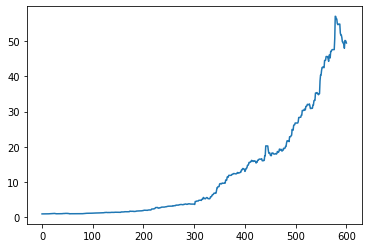

In [115]:
plt.plot(np.cumprod(1 + np.array(result)))